# Training regular Artifical Neural Network (ANN) based classifier

This is a short tutorial explaining how to convert simulation outputs into summary statistics and use them to train ANN model.

Content of this tutorial:
1. Create summary statistics from simulation outputs
2. Load and preprocess summary statistics
3. Implement ANN
4. Train and evaluate the model

All the required functions are contained in BaSe module. So should first load BaSe and define required paths:

In [1]:
%run -i ../BaSe/Preprocess.py
%run -i ../BaSe/Model.py

Using TensorFlow backend.


Now, we define paths to directories in which simulation outputs, summary statistics and trained model will be stored:

In [2]:
path_to_sim = '/Users/ulas/Projects/balancing_selection/Data/SimOuts/' # Directory where simulation outputs are stored
path_to_stat = '/Users/ulas/Projects/balancing_selection/Data/Stats/' # Directory where summary statistics will be stored
path_to_save = '/Users/ulas/Projects/balancing_selection/Data/Model/'   # Directory where trained model and data will be stored

### 1. Create summary statistics

In order to train ANN, we calculate 66 summary statistics for each simulation output. In this tutorial, we assume that simulations are performed for all classes. To learn how to run simulations, you can view `../Simulations/README.md`.

__Importantly__, this function assumes that all the simulation outputs are in the same folder with the specific file names. Given the output folder in `../Simulations/Params.txt`, the scripts in `../Simulations` produce outputs with a specific naming pattern. However, if you modify the names of simulation output files, this function may not work as expected.

`BaSe.Preprocess.sim_to_stats(path_to_sim, path_to_stat, clss, NCHROMS, SIM_FROM, SIM_TO, N, N_NE)` function reads simulation output files from `path_to_sim` folder, calculates summary statistics and saves it into an .csv file in `path_to_stat` folder. It accepts following arguments:

* __path_to_sim (string)__: Path to directory where the simulation files exist
* __path_to_stat (string)__: Path to directory where the summary statistics will be stored
* __clss (string)__: Simulation class (either FD, OD, IS or NE):
    * __NE__: Neutral
    * __IS__: Incomplete sweep
    * __OD__: Overdominance
    * __FD__: Negative frequency dependent selection
* __NCHROMS (int)__: Number of samples(haploid individuals, or chromosoms)
* __SIM_FROM (int)__: Simulation number to include -starting from
* __SIM_TO (int)__: Simulation number to include -until
* __N (int)__: Length of the simulated sequence(bp) for selection scenarios
* __N_NE (int)__: Length of simulated sequence(bp) for neutral scenario

Following code will calculate summary statistics for 500 simulations from each class and different times of onset of selection:

In [ ]:
for clss in ["NE", "IS", "OD", "FD"]:
    sim_to_stats(path_to_sim, path_to_stat, clss, NCHROMS=198, SIM_FROM=1, SIM_TO=500, N=50000, N_NE=500000)

This will create `clss.csv` (i.e., NE.csv, IS.csv, OD.csv, and FD.csv) files in specified directory. 

__Note__: For large number of samples, this may take some time. Therefore, rather than using for loop, it can be separetly run for different classes in parallel. It is important to note that, since we used 21 different times of onset of selection for selection scenarios, there will be 500x21=10,500 (500 samples for each 21 time of onset) samples for selection scenarios.

### 2. Load and preprocess summary statistics

Summary statistics can be loaded and preprocessed by `SumStats` class. Required key arguments for initiation of the object:
* __test__: Test number to be performed:
    * __1__: Neutrality vs Selection(IS+OD+FD)
    * __2__: Incomplete sweep vs Balancing selection(OD+FD)
    * __3__: Overdominance vs Negative frequency dependent selection
* __selection_category__: Specifies the time of onset of selection for selection scenarios. Possible bins:
    * __recent__: Includes selection scenarios ranging from 20k to 26k years old.
    * __medium__: Includes selection scenarios ranging from 27k to 33k years old.
    * __old__: Includes selection scenarios ranging from 34k to 40k years old.
* __N__: Number of samples that will be included per class

In [3]:
test = 1
selection_category = "recent"

stats = SumStats(test=test, selection_category=selection_category, N=500)

In this tutorial, we will try to distinguish between neutrality and selection (test 1) for a recent selection. Importantly, __N__ specifies the number of samples per class. Moreover, if the supplied value of `N` cannot be divided into equal number of samples from each class and time of selection onset, the closest `N` value will be used (i.e., largest value that can be divided into equal number of samples and not greater than the supplied `N` value).

Now, to load and preprocess summary statistics, we can use `load_sumstats()` function. It accepts following key arguments:
* __path_to_stat__: Path to directory where the summary statistics are stored
* __val_size__: Float between 0 and 1 specifying proportion of data that will used for validation
* __toshuggle__: If True, shuffles the data before splitting
* __scale__: If True, performs feature scaling
* __pca__: If True, performs pca
* __verbose__: Specifies verbosity mode. If verbose > 0, prints number of samples

In [5]:
X_train, X_val, y_train, y_val = stats.load_sumstats(path_to_stat,  val_size=0.2, toshuffle=True, scale=True,
                                                     pca=False, random_state=2, verbose=1)

Times of onset of selection for selection scenarios: [20, 21, 22, 23, 24, 25, 26]
Total sample sizes:
Neutral: 483
Selection: 483 = 161(IS) + 161(FD) + 161(OD) 

Sample sizes for each selection start time:
FD for 20 k years old selection:  23
FD for 21 k years old selection:  23
FD for 22 k years old selection:  23
FD for 23 k years old selection:  23
FD for 24 k years old selection:  23
FD for 25 k years old selection:  23
FD for 26 k years old selection:  23
IS for 20 k years old selection:  23
IS for 21 k years old selection:  23
IS for 22 k years old selection:  23
IS for 23 k years old selection:  23
IS for 24 k years old selection:  23
IS for 25 k years old selection:  23
IS for 26 k years old selection:  23
OD for 20 k years old selection:  23
OD for 21 k years old selection:  23
OD for 22 k years old selection:  23
OD for 23 k years old selection:  23
OD for 24 k years old selection:  23
OD for 25 k years old selection:  23
OD for 26 k years old selection:  23


We can now save the training and validation data using `save()` function from numpy module:

In [ ]:
import numpy as np

np.save("{}ANN_X_train_{}_{}".format(path_to_save, selection_category, test), X_train, allow_pickle=False)
np.save("{}ANN_y_train_{}_{}".format(path_to_save, selection_category, test), y_train, allow_pickle=False)
np.save("{}ANN_X_val_{}_{}".format(path_to_save, selection_category, test), X_val, allow_pickle=False)
np.save("{}ANN_y_val_{}_{}".format(path_to_save, selection_category, test), y_val, allow_pickle=False)

### 3. Implement ANN

Having training and validation data, we can build our model. BaSe module includes pre-compiled models whose parameters are optimized for each test separetly. Therefore, you can either load these models or implement a custum one.

#### a. Load model
Pre-compiled and optimized models can be loaded using `LoadANN(test)` by specifiying the test number:

In [6]:
mymodel = LoadANN(test)

#### b. Implement custom model
You can implement a custom model by using `MakeANN(input_shape, lr, units, l2_regularizer, dropout, lr_dec, initializer)`. For example, using the following code, we can create an ANN model having 3 fully connected layer (each contains 20 units), learning rate of 0.001, dropout rate of 0.5, and l2 weight decay of 0.005. It is also important to note that we use input_shape of 66 since we have 66 summary statistics (i.e. features) for each simulation.

In [ ]:
# mymodel = MakeANN(input_shape=66, lr=0.001, units=[20,20,20], dropout=0.5, lr_dec=0.0001, initializer="uniform")

Still, if you want to use a different model that cannot be created using `MakeANN` (e.g. different optimizer, or more complex structure), you can use `MakeModel(model)`. Here, the input can be any compiled keras model.

In [7]:
# mymodel = MakeModel(model)

Nevertheless, we will use the optimized and pre-compiled model in this tutorial. After loading the model, you can use `summary()` function to obtain an overview of the model:

In [8]:
mymodel.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 66)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 20)                1340      
_________________________________________________________________
batch_normalization_1 (Batch (None, 20)                80        
_________________________________________________________________
activation_1 (Activation)    (None, 20)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 20)                420       
_________________________________________________________________
batch_normalization_2 (Batch (None, 20)                80        
__________

### 4. Train and evaluate the model

Having both data and model, we are ready to train the model. To do so, we can use `fit_model()` function:

In [9]:
mymodel.fit_model(X_train, y_train, batch_size=32, epoch=5, validation_data=(X_val, y_val), verbose=2)

Train on 772 samples, validate on 194 samples
Epoch 1/5
 - 1s - loss: 0.7675 - acc: 0.5596 - val_loss: 0.4476 - val_acc: 0.9021
Epoch 2/5
 - 0s - loss: 0.6353 - acc: 0.6399 - val_loss: 0.3544 - val_acc: 0.9330
Epoch 3/5
 - 0s - loss: 0.5112 - acc: 0.7435 - val_loss: 0.2778 - val_acc: 0.9691
Epoch 4/5
 - 0s - loss: 0.4931 - acc: 0.7642 - val_loss: 0.2251 - val_acc: 0.9691
Epoch 5/5
 - 0s - loss: 0.4108 - acc: 0.8290 - val_loss: 0.1988 - val_acc: 0.9742


After the training is completed, we can access the training history as follows:

In [ ]:
# print(mymodel.train_loss)  # Prints training loss
# print(mymodel.train_acc)   # Prints training accuracy
# print(mymodel.val_loss)    # Prints validation loss
# print(mymodel.val_acc)     # Prints validation accuracy

Using `vis_acc_loss()` we can plot the training history:

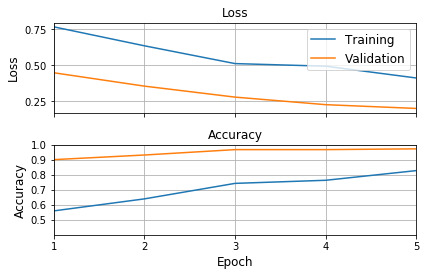

In [10]:
mymodel.vis_acc_loss()

We can also plot the confusion matrix using validation data:

194/194 [==============================] - 0s 45us/step


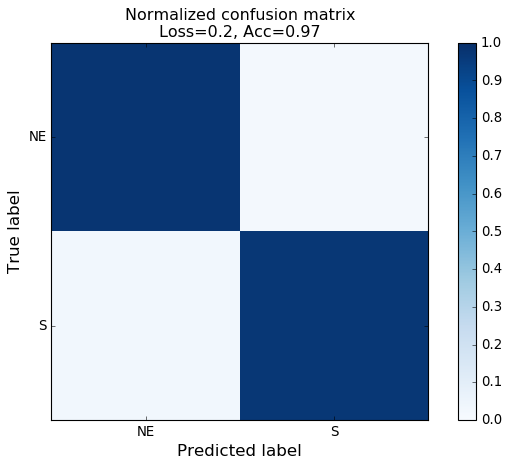

In [11]:
mymodel.vis_cm(X_val, y_val, stats.classes)

Lastly, in order to use this trained model in the testing on real data, we should save it:

In [ ]:
mymodel.save_model("{}ANN_model_{}_{}.h5".format(path_to_save, selection_category, test))